# HW 8.4


## 8.12

Add a method <code>KalmanFilter</code> to the <code>LinearModel</code> class that computes the Kalman filter. Repeat 8.11 using <code>KalmanFilter</code> instead of <code>estimate</code>, and compare computation time as well as accuracy.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time
import scipy.linalg as la

In [32]:
class LinearModel(object):
    def __init__(self, F, Q, H, R, u):
        """
        Initialize the dynamical system models.
        
        Parameters
        ----------
        F : (n,n) ndarray -- State transition model
        Q : (n,n) ndarray -- Covariance matrix for state noise
        H : (m,n) ndarray -- Observation model
        R : (m,m) ndarray -- Covariance matrix for observation noise
        u : (n,) ndarray -- Control vector
        """
        self.F = F
        self.Q = Q
        self.H = H
        self.R = R
        self.u = u
        
        self.n = F.shape[0]
        self.m = R.shape[0]
        
    
    def evolve(self, x0, N):
        """
        Compute the first N states and observations 
        generated by the linear system.
        
        Parameters
        ----------
        x0 : (n,) ndarray -- The initial state
        N : int -- The number of steps to evolve.
        
        Returns
        -------
        states : (n,N) ndarray -- States 0 through N-1, given by each column
        obs : (m,N) ndarray -- Observations 0 through N-1, given by each column
        """
        # note, here we build the states transposed, where each state is a row
        states = np.empty((N,self.n))
        obs = np.empty((N,self.m))
        states[0] = x0
        obs[0] = self.H @ x0 + np.random.multivariate_normal(np.zeros(self.m), self.R)
        
        for i in range(N-1):
            states[i+1] = self.F @ states[i] + self.u + np.random.multivariate_normal(np.zeros(self.n),self.Q)
            obs[i+1] = self.H @ states[i+1] + np.random.multivariate_normal(np.zeros(self.m), self.R)
            
        return states.T, obs.T
    
    def estimate(self, x0, P, y):
        """
        comupte the state etsimates using the Kalman filter.
        If x0 and P correspond to time step k, then y is a sequence of
        observations starting at time step k+1.
        
        Parameters
        ----------
        x0 : array (n) - The initial state estimate
        P : matrix (n,n) - The initial error covariance matrix.
        y : matrix (m,N) - Sequence of N observations, each column an obs
        
        Returns
        -------
        out : array (n,N) - Sequence of state estimates, each column an estimate
        """
        x = [x0]
        P = P.copy()
        
        for yk in y.T:
            # Predictive step
            pred_x = self.F @ x[-1] + self.u
            pred_P = self.F @ P @ self.F.T + self.Q
            
            # Update step
            P = np.linalg.inv(np.linalg.inv(pred_P) + self.H.T @ np.linalg.inv(self.R) @ self.H)
            x.append( pred_x - P @ self.H.T @ np.linalg.inv(self.R) @ (self.H @ pred_x - yk) )
            
        return np.array(x).T
    
    def KalmanFilter(self, x0, P, y):
        x = [x0]
        P = P.copy()
        
        for yk in y.T:
            # Predictive step
            pred_x = self.F @ x[-1] + self.u
            pred_P = self.F @ P @ self.F.T + self.Q
            
            # Update step
            K = pred_P @ self.H.T @ np.linalg.inv(self.H @ pred_P @ self.H.T + self.R)
            P = (np.eye(len(pred_P)) - K @ self.H) @ pred_P
            x.append( pred_x + K @ (yk - self.H @ pred_x) )
            
        return np.array(x).T
    
    ## 8.13
    def predict(self, x0, k):
        """
        Predict the next k states in the absence of observations

        Parameters
        ----------
        x : array (n) - the current state estimate
        k : integer - the number of states to predict

        Returns
        -------
        out : array (n,k) - the next k predicted states, states as columns
        """
        x = [x0]
        for _ in range(k):
            x.append(self.F @ x[-1] + self.u)
            
        return np.array(x).T
    
    ## 8.16
    def rewind(self, x0, k):
        """
        Predict the k states preceding the current state estimate x0
        
        Parameters
        ----------
        x : array (n) - current state estimate
        k : integer - the number of preceeding states to predict
        
        Returns
        -------
        out : array (n,k) - the k preceeding states
        """
        x = [x0]
        
        # Precompute F inverse 
        F_inv = np.linalg.inv(self.F)
        
        # rewind
        for _ in range(k):
            x.insert(0,F_inv @ (x[0] - self.u))
        
        return np.array(x).T
    
    def SquareRootFilter(self, x0, P, y):
        # step i.)
        x = [x0]
        P = P.copy()
        
        # step ii.)
        S = np.linalg.cholesky(P)
        
        T = la.sqrtm(self.Q)
        
        # step iii.)
        for yk in y.T:
            # step iv.)
            
            M = np.hstack((self.F @ S, T))
            
            # step v.)
            pred_S = np.linalg.cholesky(M @ M.T)
            
            # step vi.)
            pred_P = pred_S @ pred_S.T
            pred_x = self.F @ x[-1] + self.u
            
            # step vii.)
            L = np.linalg.cholesky(self.H @ pred_P @ self.H.T + self.R)
            L_inv = np.linalg.inv(L)
            V = np.linalg.cholesky(self.R)
            
            # step viii.)
            S = pred_S @ (np.eye(len(pred_S.T)) - pred_S.T @ self.H.T @ L_inv.T @ np.linalg.inv(L + V) @ self.H @ pred_S)
            
            # step ix.)
            K = pred_P @ self.H.T @ L_inv.T @ L_inv
            
            # step x.)
            x.append(pred_x + K @ (yk - self.H @ pred_x))
            P = S @ S.T
        
        return np.array(x).T

### (8.11)

Returning to the projectile example, assume that the radar sensor has taken observations from time steps 200 through 800 (take the corresponding slice of the observations produced in 8.8). Use these observatinos to estimate the corresponding true states of the projectile at those times.

(i.) Construct an estimate $\hat{x}_{200}$ for state 200 as follows: For the horizontal and vertical positions, simply use the observed position at time 200. For the velocity, compute the average velocity between the ovservations for $k = 200, ..., 208$.


In [12]:
# Instantiate a la 8.2.6
timestep = 0.1

F = np.eye(4) + np.diag([timestep, timestep], k=2)
Q = 0.1 * np.eye(4)
H = np.hstack((np.eye(2), np.zeros((2,2))))
R = 5000 * np.eye(2)
u = np.array([0,0,0,-9.8 * timestep])
x0 = np.array([0,0,300,600])
model = LinearModel(F,Q,H,R,u)

# Get the first 1250 states and observations
x, y = model.evolve(x0, 1250)

# Estimate velocity
v = np.diff(y[:,200:209]).mean(1)

# Pick starting estimate
x_hat = np.array([*y[:,200], *v])



(ii.) Use the initial accuracy estimate $P_{200} = 10^6 \dot Q$ and feed $P_{200}, \hat{x}_{200}$, and $y_{201}, ... , y_{800}$ to the Kalman filter to obtain estimates for $x_{201}, ... , x_{800}$


In [13]:

P = 10 ** 6 * model.Q

# Time the old way
start = time.time()
x_predictions = model.estimate(x_hat, P, y[:, 201:801])
est_time = time.time() - start

# Time the new way
start = time.time()
x_K_predictions = model.estimate(x_hat, P, y[:,201:801])
K_time = time.time() - start

# Compare accuracies
est_acc = sum(np.linalg.norm(x[:,200:801] - x_predictions, axis=0))
K_acc = sum(np.linalg.norm(x[:,200:801] - x_K_predictions,axis=0))

# Print comparison
print("'estimate' runtime:", est_time)
print("'KalmanFilter' runtime:", K_time)
print()
print("'estimate' Sum Squared Error:", est_acc)
print("'KalmanFilter' Sum Squared Error:",K_acc)
print()
print("(KalmanFliter is faster, while both produce equal predictions)")

'estimate' runtime: 0.03989291191101074
'KalmanFilter' runtime: 0.03390932083129883

'estimate' Sum Squared Error: 13053.75707716101
'KalmanFilter' Sum Squared Error: 13053.75707716101

(KalmanFliter is faster, while both produce equal predictions)


## 8.13
Add a method to the <code>LinearModel</code> class that predicts the next k states, given a current state estimate, but in the absence of observations. (See <code>LinearModel</code> above) 

## 8.14

Using the final state estimate obtained in Problem 11, predict the future states of the projectile until it hits the ground. Predicting the next 450 states should be sufficient.

Plot the actual states together and observe how near the prediction is to the actual point of impact.

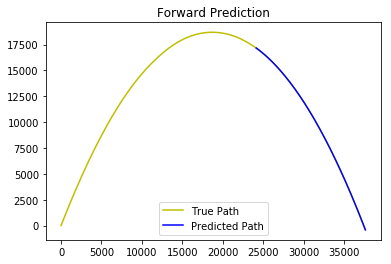

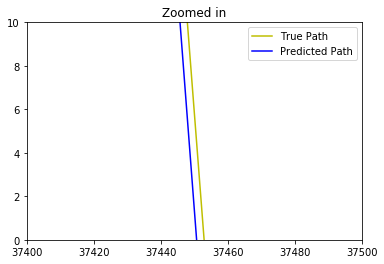

In [29]:
# Get predicted path and true path
pred_path = model.predict(x_K_predictions[:,-1],450)


plt.plot(*x[:2], 'y', label="True Path")
plt.plot(*pred_path[:2], 'b', label="Predicted Path")
plt.title("Forward Prediction")
plt.legend()
plt.show()

plt.plot(*x[:2], 'y', label="True Path")
plt.plot(*pred_path[:2], 'b', label="Predicted Path")
plt.title("Zoomed in")
plt.legend()
plt.xlim(37400,37500)
plt.ylim(0,10)
plt.show()


## 8.15 
Sure thing

## 8.16
Implement <code>rewind</code>, (See <code>LinearModel</code>)

## 8.17

(i.) Predict the point of origin from estimate of $\hat{x}_{250}$

In [15]:
rev_prod = model.rewind(x_K_predictions[:,50],260)

origin_idx = max(np.where(rev_prod[1] <= 0)[0])
origin = rev_prod[:,origin_idx]
print("Predicted x position of origin =", origin[0])

Predicted x position of origin = -85.96984662098455


(ii.) Plot these predicted states in yellow together with the original state sequence in blue.

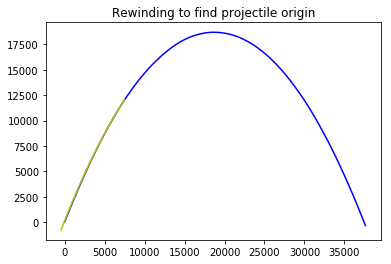

In [16]:
plt.plot(*x[:2],'b',label="True State")
plt.plot(*rev_prod[:2],'y',label="Prediction")
plt.title("Rewinding to find projectile origin")
plt.show()


(iii.) Zoom in to see how accurate your prediction is. (Similar to 8.5)

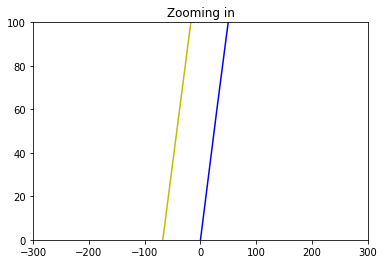

In [17]:
plt.plot(*x[:2],'b',label="True State")
plt.plot(*rev_prod[:2],'y',label="Prediction")
plt.title("Zooming in")
plt.xlim(-300,300)
plt.ylim(0,100)
plt.show()

(iv.) Repeat starting at 600. Compare to previous results. Which is better? Why?

Predicted x position of origin = -76.71120587847447


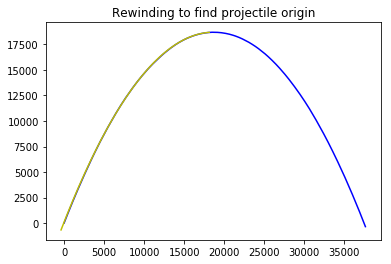

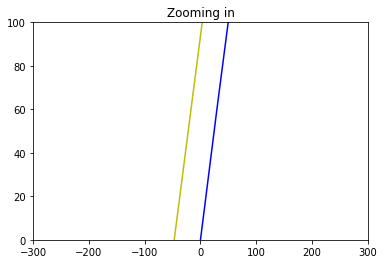

In [18]:
rev_prod = model.rewind(x_K_predictions[:,400],610)

origin_idx = max(np.where(rev_prod[1] <= 0)[0])
origin = rev_prod[:,origin_idx]
print("Predicted x position of origin =", origin[0])

plt.plot(*x[:2],'b',label="True State")
plt.plot(*rev_prod[:2],'y',label="Prediction")
plt.title("Rewinding to find projectile origin")
plt.show()

plt.plot(*x[:2],'b',label="True State")
plt.plot(*rev_prod[:2],'y',label="Prediction")
plt.title("Zooming in")
plt.xlim(-300,300)
plt.ylim(0,100)
plt.show()

Thus we see that the prediction starting from 600 is more accurate than predicting from 250. This is likely because the state estimate improves as time goes on, so starting from 600 (a better estimate) is better than starting closer but using a worse starting estimate

## 8.18
Add a method <code>SquareRootFilter</code>. Compare the computation time and accuracy of the results with those for estimate and KalmanFilter applied to the same problem.

In [30]:
# Time the SquareRootFilter
P = 10 ** 6 * model.Q

start = time.time()
sqrt_predictions = model.SquareRootFilter(x_hat, P, y[:, 201:801])
sqrt_time = time.time() - start

sqrt_acc = sum(np.linalg.norm(x[:,200:801] - sqrt_predictions,axis=0))


In [33]:
# Print comparison
print("'estimate' runtime:", est_time)
print("'KalmanFilter' runtime:", K_time)
print("'SquareRootFilter' runtime:",sqrt_time)
print()
print("'estimate' Sum Squared Error:", est_acc)
print("'KalmanFilter' Sum Squared Error:",K_acc)
print("'SquareRootFilter' Sum Squared Error:",sqrt_acc)
print()
print("(SqareRootFilter is significantly slower, while all produce relatively equal predictions)")

'estimate' runtime: 0.03989291191101074
'KalmanFilter' runtime: 0.03390932083129883
'SquareRootFilter' runtime: 0.17356443405151367

'estimate' Sum Squared Error: 13053.75707716101
'KalmanFilter' Sum Squared Error: 13053.75707716101
'SquareRootFilter' Sum Squared Error: 13053.757077160928

(SqareRootFilter is significantly slower, while all produce relatively equal predictions)
